In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [97]:
features = ['duration',
 'spectral_bandwidth_kurtosis_01',
 'spectral_bandwidth_max_01',
 'spectral_bandwidth_mean_01',
 'spectral_bandwidth_median_01',
 'spectral_bandwidth_min_01',
 'spectral_bandwidth_skew_01',
 'spectral_bandwidth_std_01',
 'spectral_centroid_kurtosis_01',
 'spectral_centroid_max_01',
 'spectral_centroid_mean_01',
 'spectral_centroid_median_01',
 'spectral_centroid_min_01',
 'spectral_centroid_skew_01',
 'spectral_centroid_std_01',
 'spectral_rolloff_kurtosis_01',
 'spectral_rolloff_max_01',
 'spectral_rolloff_mean_01',
 'spectral_rolloff_median_01',
 'spectral_rolloff_min_01',
 'spectral_rolloff_skew_01',
 'spectral_rolloff_std_01',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'speechiness',
 'tempo',
 'valence']

target_col = 'genre_title'


In [98]:
test_data = pd.read_csv('../DataBase/processed/test_data.csv')
train_data = pd.read_csv('../DataBase/processed/train_data.csv')

In [99]:
genre_labels = ['Hip-Hop', 'Rock', 'Electronic', 'Pop', 'International',
       'Experimental', 'Blues', 'Jazz', 'Folk', 'Country', 'Spoken',
       'Classical', 'Instrumental', 'Old-Time / Historic', 'Soul-RnB',
       'Easy Listening']
genre_labels_encoded = [k for k in range(len(genre_labels))]

In [100]:
le = LabelEncoder()
train_data[target_col] = le.fit_transform(train_data[target_col])

mapping = dict(zip(le.classes_, np.arange(len(le.classes_))))
print(mapping)

{'Blues': np.int64(0), 'Classical': np.int64(1), 'Electronic': np.int64(2), 'Experimental': np.int64(3), 'Folk': np.int64(4), 'Hip-Hop': np.int64(5), 'Instrumental': np.int64(6), 'International': np.int64(7), 'Jazz': np.int64(8), 'Old-Time / Historic': np.int64(9), 'Pop': np.int64(10), 'Rock': np.int64(11)}


In [101]:
le = LabelEncoder()
test_data[target_col] = le.fit_transform(test_data[target_col])

mapping = dict(zip(le.classes_, np.arange(len(le.classes_))))
print(mapping)

{'Blues': np.int64(0), 'Classical': np.int64(1), 'Electronic': np.int64(2), 'Experimental': np.int64(3), 'Folk': np.int64(4), 'Hip-Hop': np.int64(5), 'Instrumental': np.int64(6), 'International': np.int64(7), 'Jazz': np.int64(8), 'Old-Time / Historic': np.int64(9), 'Pop': np.int64(10), 'Rock': np.int64(11)}


In [102]:
X_train, y_train, X_test, y_test = train_data[features], train_data[target_col], test_data[features], test_data[target_col]

In [103]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [104]:
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.81      0.81      0.81        37
           2       0.67      0.75      0.71       364
           3       1.00      0.33      0.50         3
           4       0.52      0.43      0.47       106
           5       0.75      0.66      0.70       156
           6       0.00      0.00      0.00        24
           7       1.00      0.19      0.32        16
           8       1.00      0.12      0.22        40
           9       1.00      0.97      0.98        65
          10       0.20      0.02      0.03        56
          11       0.69      0.86      0.76       500

    accuracy                           0.69      1374
   macro avg       0.64      0.43      0.46      1374
weighted avg       0.67      0.69      0.66      1374



c:\Users\Lesli\Downloads\anaconda3\envs\env_hackathon\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lesli\Downloads\anaconda3\envs\env_hackathon\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lesli\Downloads\anaconda3\envs\env_hackathon\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

C:\Users\Lesli\AppData\Local\Temp\ipykernel_7036\867494336.py:2: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)


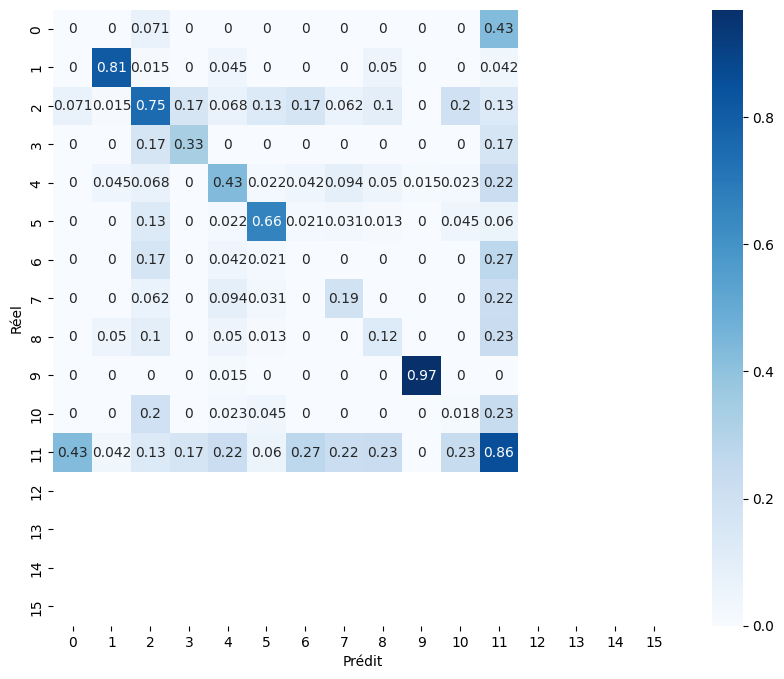

In [105]:
cm = confusion_matrix(y_test, predictions, labels=genre_labels_encoded)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
similarity = (cm_norm + cm_norm.T) / 2
plt.figure(figsize=(10,8))
sns.heatmap(similarity, annot=True, cmap="Blues", xticklabels=genre_labels_encoded, yticklabels=genre_labels_encoded)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

In [106]:
xgb = XGBClassifier(eval_metric="mlogloss")
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.33      0.14      0.20         7
           1       0.88      0.76      0.81        37
           2       0.71      0.79      0.75       364
           3       0.00      0.00      0.00         3
           4       0.51      0.50      0.50       106
           5       0.78      0.74      0.76       156
           6       0.33      0.04      0.07        24
           7       1.00      0.06      0.12        16
           8       0.71      0.25      0.37        40
           9       1.00      0.94      0.97        65
          10       0.69      0.16      0.26        56
          11       0.71      0.84      0.77       500

    accuracy                           0.72      1374
   macro avg       0.64      0.43      0.47      1374
weighted avg       0.71      0.72      0.70      1374



c:\Users\Lesli\Downloads\anaconda3\envs\env_hackathon\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lesli\Downloads\anaconda3\envs\env_hackathon\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lesli\Downloads\anaconda3\envs\env_hackathon\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

Idée : relier les classes les moins bien représentées/ moins bien prédites avec une proche

C:\Users\Lesli\AppData\Local\Temp\ipykernel_7036\867494336.py:2: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)


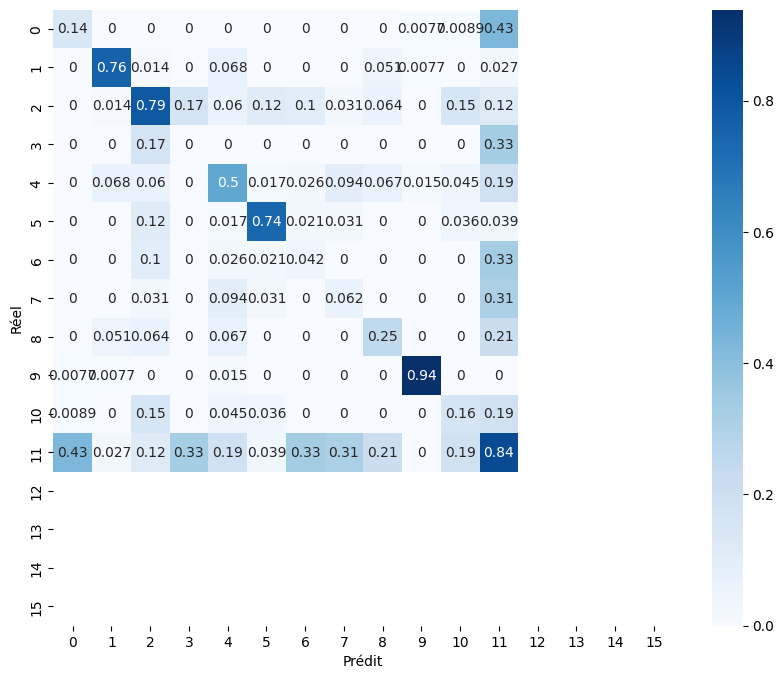

In [107]:
cm = confusion_matrix(y_test, predictions, labels=genre_labels_encoded)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
similarity = (cm_norm + cm_norm.T) / 2
plt.figure(figsize=(10,8))
sns.heatmap(similarity, annot=True, cmap="Blues", xticklabels=genre_labels_encoded, yticklabels=genre_labels_encoded)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()